# **CHALLENGE 2 : Prediction of Phishing URL's**

# Introduction
With the proliferation of the World Wide Web and the increasing sophistication of cyber threats, phishing attacks have emerged as a significant concern for individuals and organizations alike.
This notebook tackles Challenge 2 for phishing URL detection.

## Objective
The aim behind this challenge is to develop a model that accurately classifies URLs as either phishing or legitimate. Therefore, We will benchmark several models to find the best-performing one based on accuracy and F1-Score.

## Dataset
The PhiUSIIL Phishing URL Dataset used in this project is substantial, comprising **134,850 legitimate URLs** and **100,945 phishing URLs**.
Most of the URLs in the dataset are recent, representing the latest tactics and structures observed in phishing schemes. The features in this dataset are extracted from both the source code of the webpages and the URLs themselves, providing a rich foundation for understanding the characteristics of phishing and legitimate URLs.

Prasad, A., & Chandra, S. (2023). PhiUSIIL: A diverse security profile empowered phishing URL detection framework based on similarity index and incremental learning. Computers & Security, 103545. doi: https://doi.org/10.1016/j.cose.2023.103545

## Target Variable
The target variable `label` represents the phishing status of a URL. **1** refers to a legitimate URL while **0** to a phishing one.







# **Warm up**

#### **Dataset loading**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
df = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv',delimiter=',')
df.shape

(235795, 56)

#### **Removing columns derived from existing features**



In [ ]:
columns_to_remove = [
    'URLSimilarityIndex',
    'CharContinuationRate',
    'URLTitleMatchScore',
    'URLCharProb',
    'TLDLegitimateProb'
]
df.drop(columns_to_remove, axis=1, inplace=True)

In [ ]:
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


### **Descriptive statistics and feature engineering**

In [ ]:
df.describe()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,78.430778,0.845508,0.260423,0.055747,2.764456,1.164758,0.002057,...,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516,0.571895
std,41.314153,9.150793,0.051946,28.976055,0.216632,0.251628,0.010587,0.599739,0.600969,0.045306,...,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430,0.494805
min,13.000000,4.000000,0.000000,0.155574,0.000000,0.000000,0.001083,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,57.024793,0.680000,0.005977,0.050747,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.000000,20.000000,0.000000,100.000000,1.000000,0.079963,0.057970,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000,1.000000
75%,34.000000,24.000000,0.000000,100.000000,1.000000,0.522907,0.062875,3.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,29.000000,8.000000,15.000000,88.000000,1.000000,57.000000,1.000000
max,6097.000000,110.000000,1.000000,100.000000,1.000000,0.522907,0.090824,13.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,8956.000000,35820.000000,6957.000000,27397.000000,4887.000000,27516.000000,1.000000


In [ ]:
df.isna().sum()

,0
FILENAME,0
URL,0
URLLength,0
Domain,0
DomainLength,0
IsDomainIP,0
TLD,0
URLSimilarityIndex,0
CharContinuationRate,0
TLDLegitimateProb,0


There are no missing values in our dataset.

#### Duplicated URLs

In [ ]:
duplicate_urls = df[df.duplicated('URL')]
print(f"Number of duplicate URLs: {len(duplicate_urls)}")

Number of duplicate URLs: 425


In [ ]:
urls = df['URL'].value_counts()
urls_duplicated = urls[urls == 2].index

filtered_df = df[df['URL'].isin(urls_duplicated)]
filtered_df.label.value_counts()

,count
label,
0,850


All the duplicated URLs are phishing URLs.

### **Feature Analysis**

To streamline feature engineering and analysis, we organized dataset columns into six themes:

1. **URL Structure**: Analyzes URL and domain properties.
2. **Content & Metadata**: Focuses on title and content attributes.
3. **Security Features**: Examines security indicators like HTTPS and obfuscation.
4. **Site Attributes**: Looks at site responsiveness, redirects, and descriptive elements.
5. **Interactive Elements**: Includes form submission and hidden fields.
6. **Response/Behavior Analysis**: Assesses behavioral indicators, multimedia, and external references.

#### 1. URL Structure


<ipython-input-187-e669fcc44b14>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='IsDomainIP', palette='Set2')


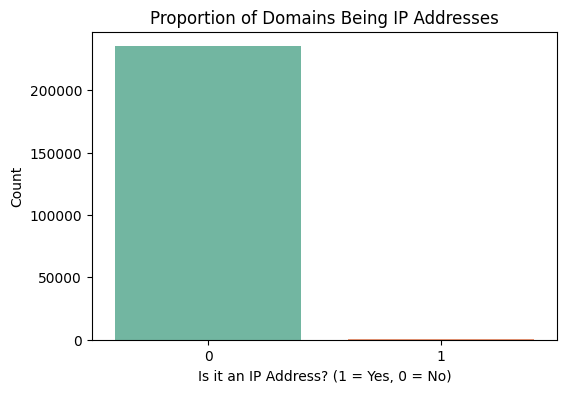

In [ ]:
# Domain Type (IP address or domain name)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='IsDomainIP', palette='Set2')
plt.title('Proportion of Domains Being IP Addresses')
plt.xlabel('Is it an IP Address? (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

In [ ]:
df[df['IsDomainIP']==1]['label'].value_counts()

,count
label,
0,638


This feature is not balanced. All the adressIP URLs are phishing. It can be a discriminative feature.

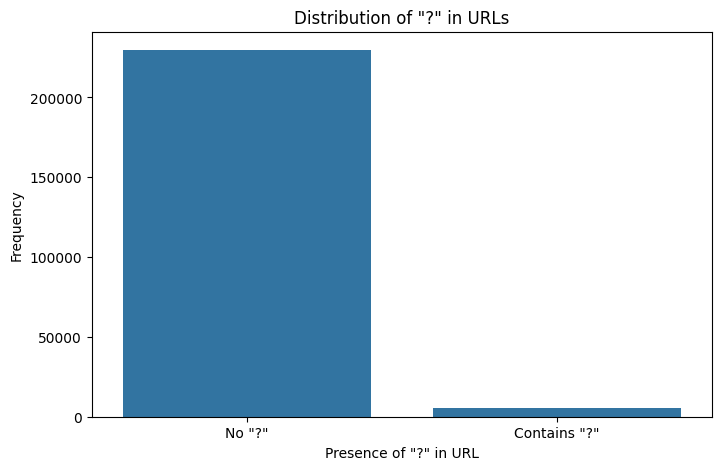

In [ ]:
# Count occurrences of 0 and 1 in NoOfQMarkInURL with centered bars
plt.figure(figsize=(8, 5))
sns.countplot(x='NoOfQMarkInURL', data=df, order=[0, 1])
plt.title('Distribution of "?" in URLs')
plt.xlabel('Presence of "?" in URL')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No "?"', 'Contains "?"'])
plt.show()

The presence of a question mark in the URL does not correlate with phishing, as it is commonly used in legitimate URLs to indicate the start of query parameters for passing data.

In [ ]:
columns_of_interest = [
    'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'TLDLength', 'NoOfSubDomain',
    'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL',
    'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
    'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL'
]

df_reduced = df[columns_of_interest]
df_reduced.head()

,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,3,1,18,0.581,0,0.0,0,0,0,1,0.032
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,2,1,9,0.391,0,0.0,0,0,0,2,0.087
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,2,2,15,0.517,0,0.0,0,0,0,2,0.069
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,3,1,13,0.500,0,0.0,0,0,0,1,0.038
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,3,1,20,0.606,0,0.0,0,0,0,1,0.030


<ipython-input-191-6764c388184a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['label'] = df['label']


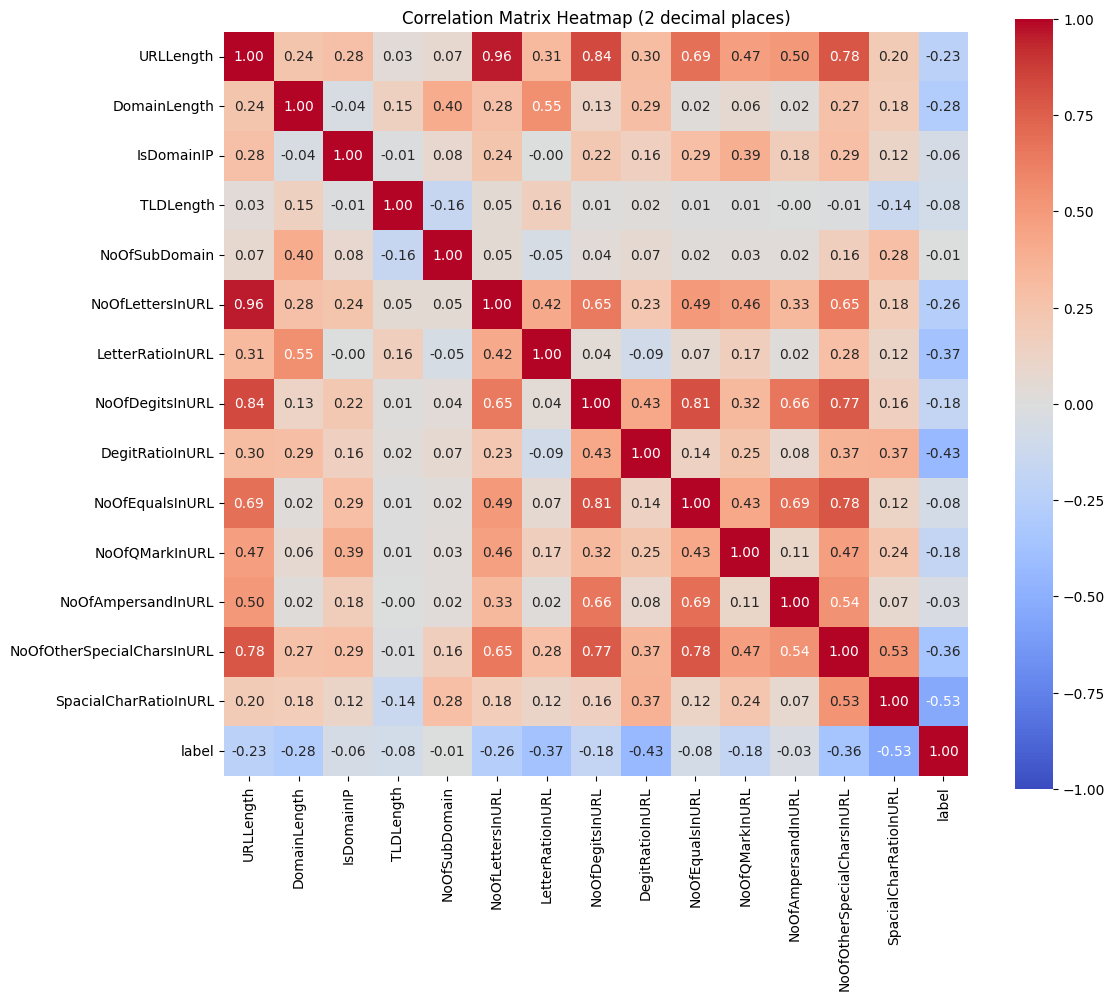

In [ ]:
df_reduced['label'] = df['label']

numeric_columns = df_reduced.select_dtypes(include='number')

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap (2 decimal places)")
plt.show()


The feature SpecialCharRatioInURL shows a strong negative correlation with the label, indicating that as the ratio of special characters in the URL increases, the likelihood of the URL being classified as phishing becomes higher.

#### 2. Content & Metadata

In [ ]:
columns_of_interest = [
    "Title",
    "HasTitle",
    "DomainTitleMatchScore",
    "LineOfCode",
    "LargestLineLength",
    "label"
]
df_reduced = df[columns_of_interest]
df_reduced.head()

,Title,HasTitle,DomainTitleMatchScore,LineOfCode,LargestLineLength,label
0,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,1,0.000000,558,9381,1
1,johannes gutenberg-universitÃ¤t mainz,1,55.555556,618,9381,1
2,voice fm southampton,1,46.666667,467,682,1
3,home page: seminars in fetal and neonatal medi...,1,0.000000,6356,26824,1
4,fundaciÃ³n rewilding argentina,1,100.000000,6089,28404,1


In [ ]:
from sklearn.preprocessing import LabelEncoder

<ipython-input-194-85e7c4249061>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['Title']=le.fit_transform(df_reduced.Title)


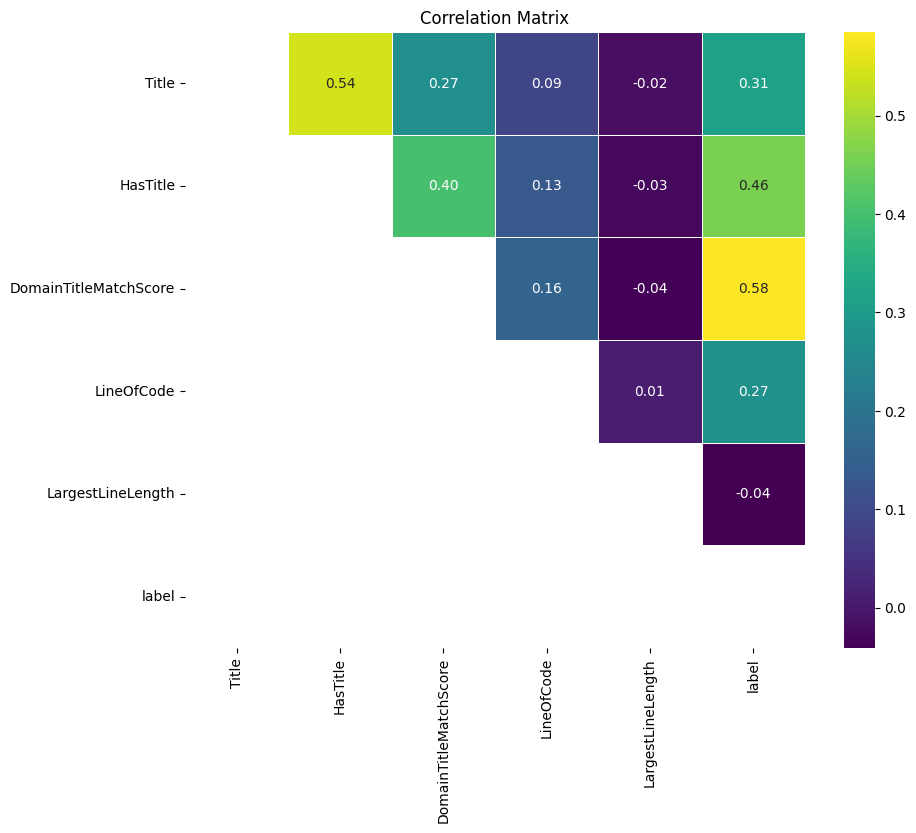

In [ ]:
le = LabelEncoder()
df_reduced['Title']=le.fit_transform(df_reduced.Title)
cor = df_reduced.corr()

mask = np.tril(np.ones_like(cor, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(cor, mask=mask, annot=True, cmap='viridis', linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


'**DomainTitleMatchScore**', which evaluates the level of alignment between a website's domain name and its page title, is the most correlated with '**label**'.

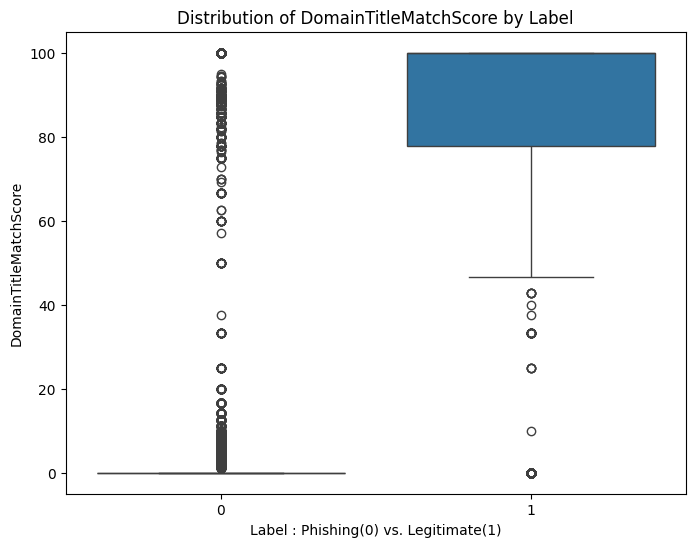

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='label', y='DomainTitleMatchScore') # 0:Phishing 1:Legitimate
plt.title("Distribution of DomainTitleMatchScore by Label")
plt.xlabel('Label : Phishing(0) vs. Legitimate(1)')

plt.show()

The boxplot provides a clear distinction between phishing and legitimate sites based on the DomainTitleMatchScore. For phishing sites, scores are low; which means that phishing sites often lack alignment in their domain and title.

#### 3. Security Features

In [ ]:
data1= df.loc[:,['IsHTTPS',
                    'Robots',
                    'HasCopyrightInfo',
                    'NoOfObfuscatedChar',
                    'ObfuscationRatio',
                    'HasObfuscation',
                    'label']
            ]

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IsHTTPS             235795 non-null  int64  
 1   Robots              235795 non-null  int64  
 2   HasCopyrightInfo    235795 non-null  int64  
 3   NoOfObfuscatedChar  235795 non-null  int64  
 4   ObfuscationRatio    235795 non-null  float64
 5   HasObfuscation      235795 non-null  int64  
 6   label               235795 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 12.6 MB


In [ ]:
data1.describe()

,IsHTTPS,Robots,HasCopyrightInfo,NoOfObfuscatedChar,ObfuscationRatio,HasObfuscation,label
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,0.782625,0.266541,0.486775,0.024861,0.000138,0.002057,0.571895
std,0.412461,0.442151,0.499826,1.876249,0.003817,0.045306,0.494805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,447.000000,0.348000,1.000000,1.000000


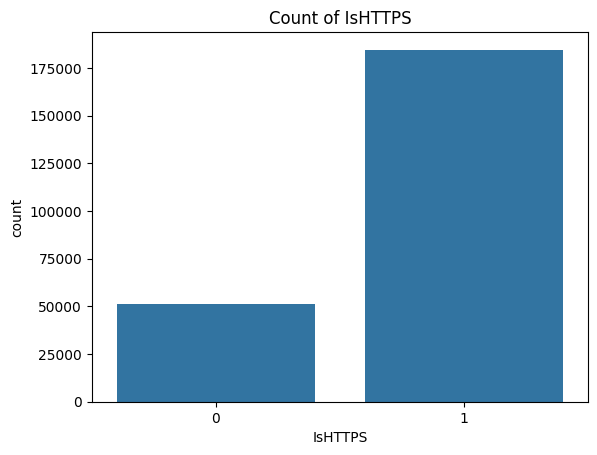

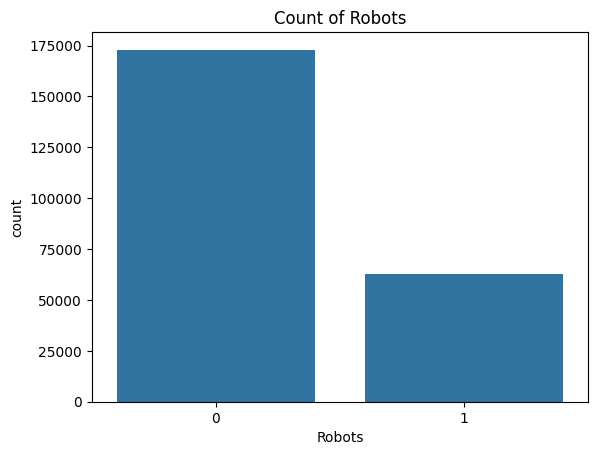

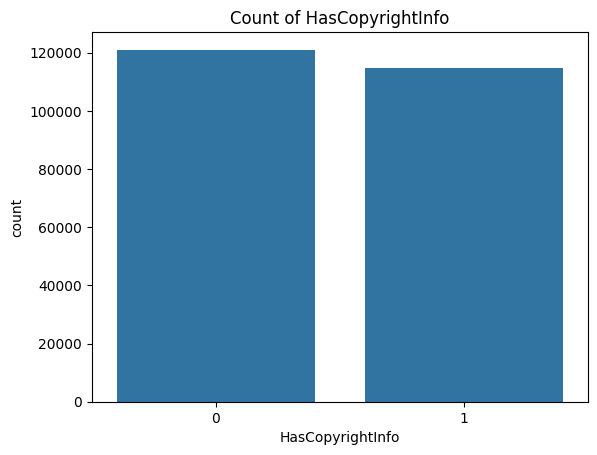

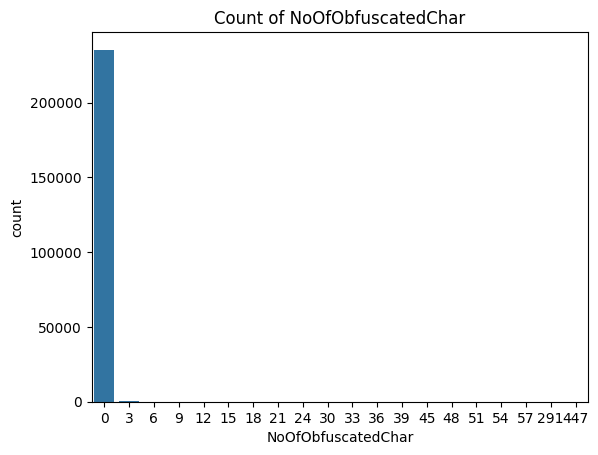

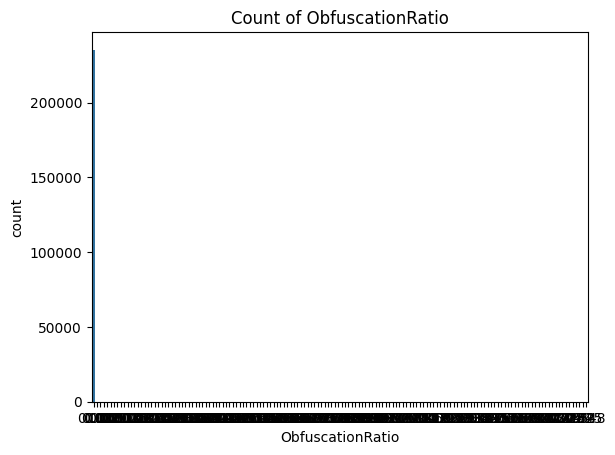

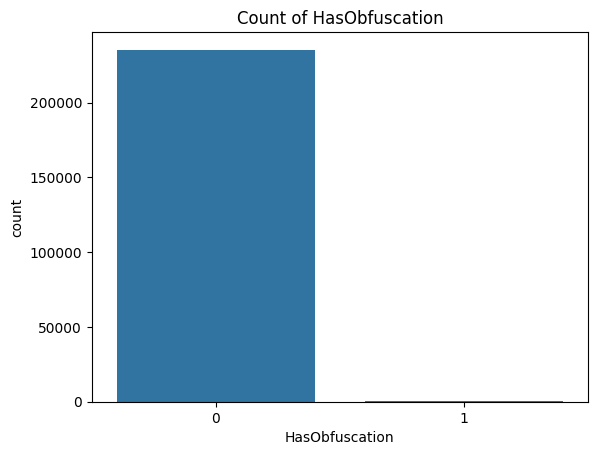

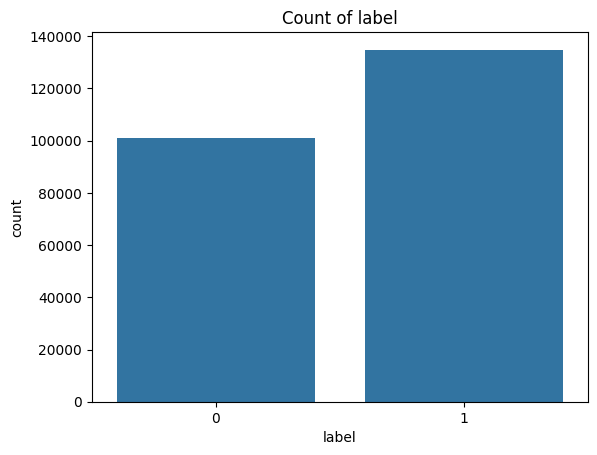

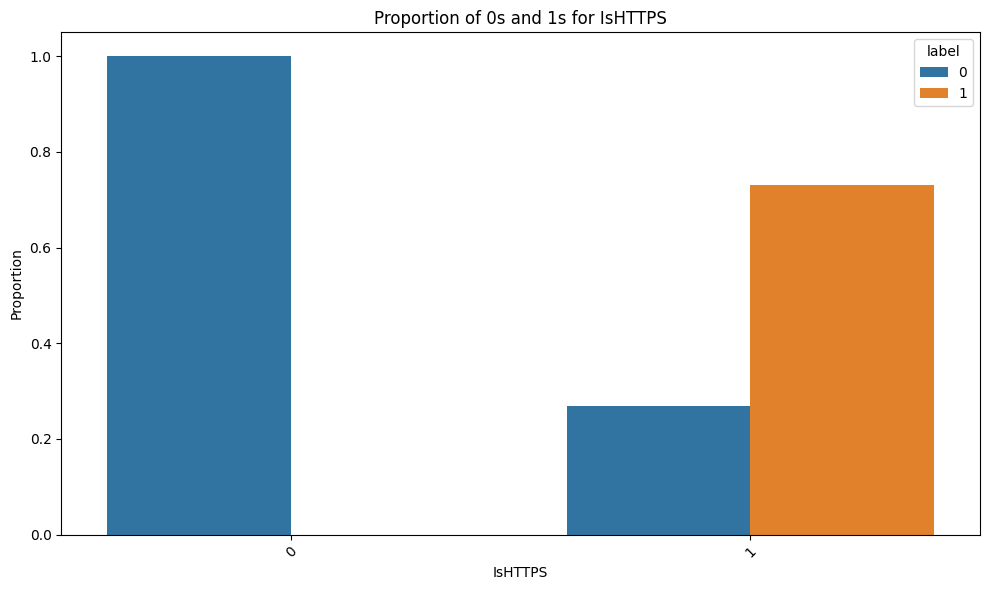

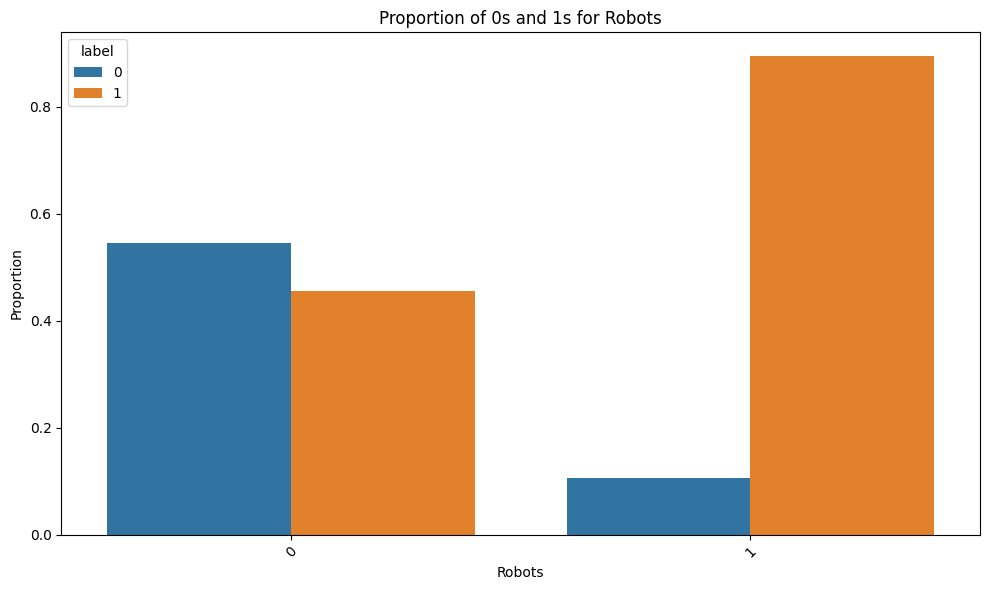

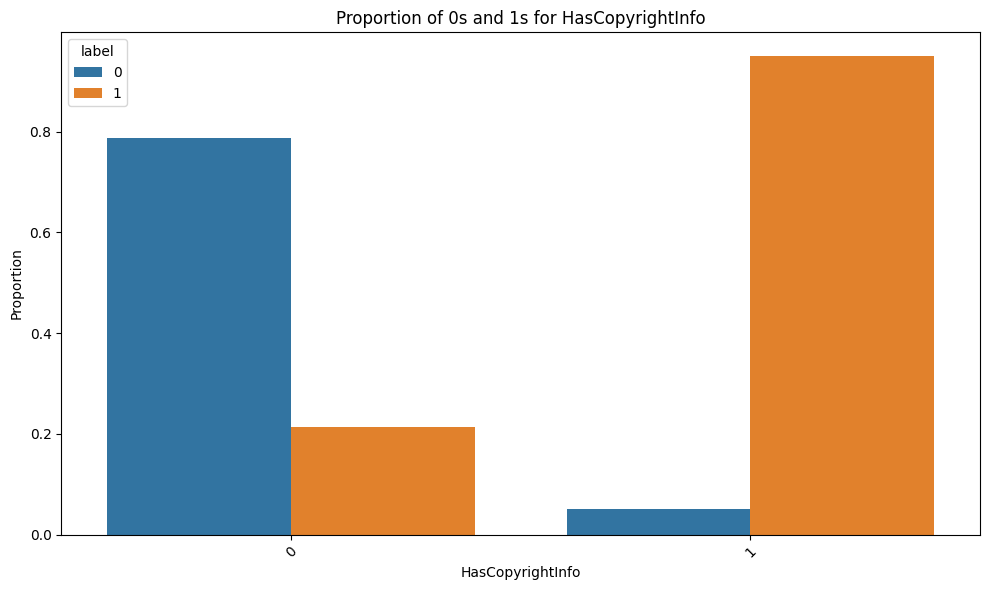

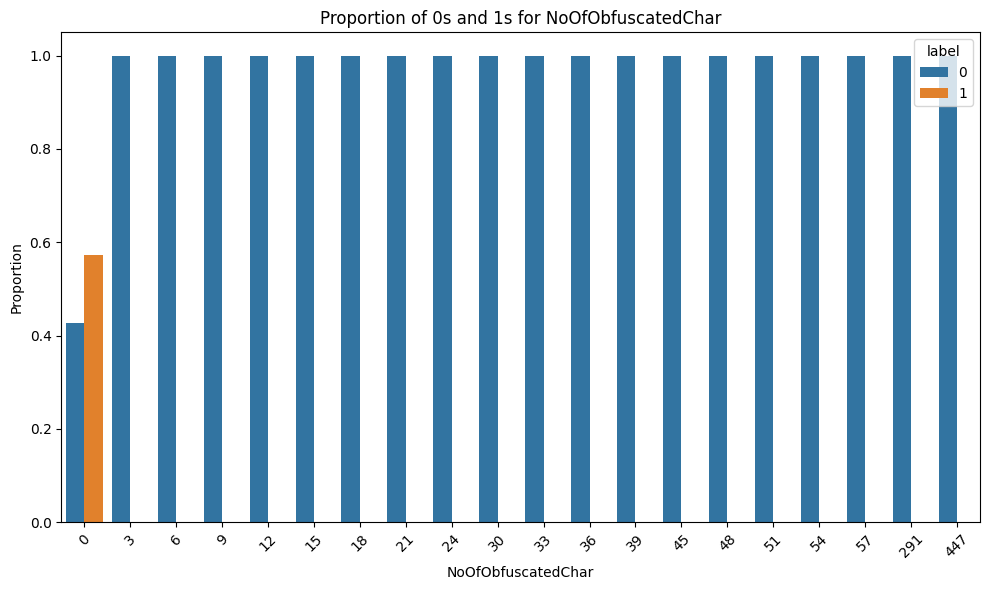

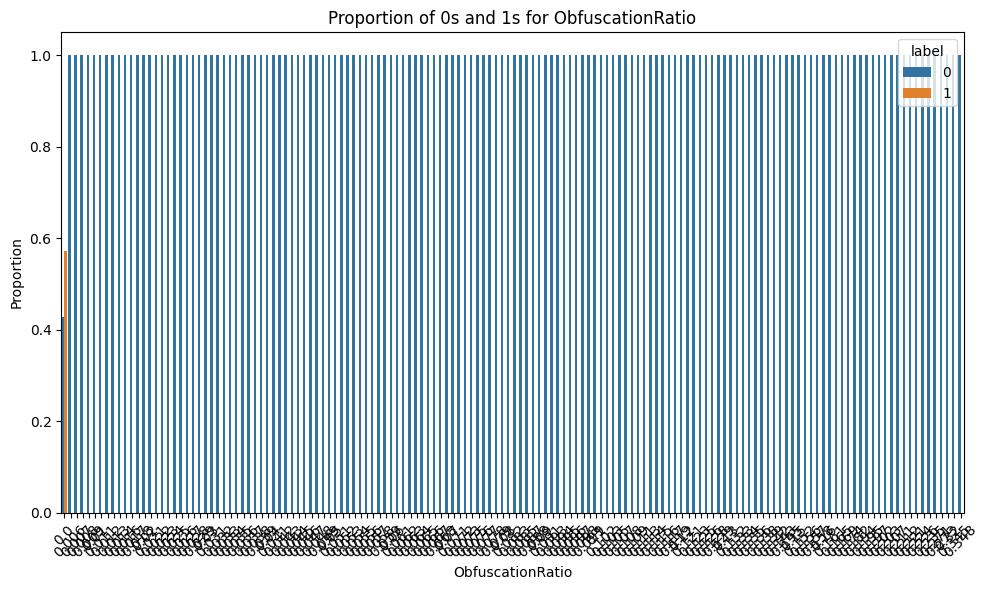

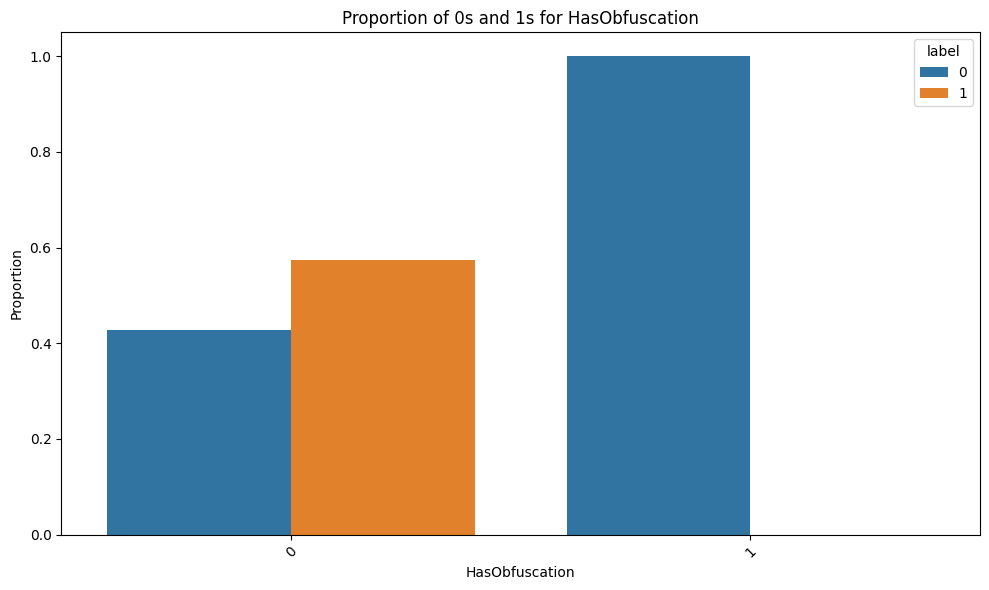

In [ ]:
numerical_columns = data1.columns
for col in numerical_columns:
    plt.figure()
    sns.countplot(x=col, data=data1)
    plt.title(f'Count of {col}')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

label_col = 'label'

numerical_columns = [col for col in data1.columns if col != label_col]

for col in numerical_columns:
    plot_data = data1.groupby([col, label_col]).size().reset_index(name='count')

    plot_data = plot_data.set_index(col)
    plot_data['proportion'] = plot_data.groupby(level=0)['count'].apply(lambda x: x / x.sum()).values
    plot_data.reset_index(inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=col, y='proportion', hue=label_col, data=plot_data)
    plt.title(f'Proportion of 0s and 1s for {col}')
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

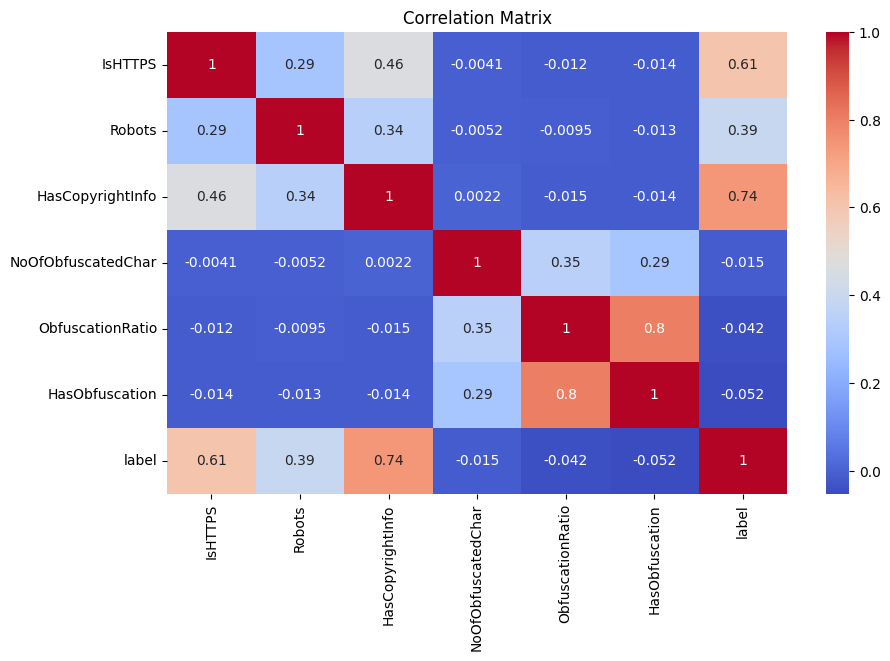

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(data1.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

#### 4. Site Attributes


In [ ]:
columns_of_interest = ['IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'HasFavicon']

In [ ]:
columns_of_interest_with_label = columns_of_interest + ['label']

data_subset = df[columns_of_interest_with_label]

correlation_matrix = data_subset.corr()
correlation_with_label = correlation_matrix['label'].drop('label')
print(correlation_with_label)

IsResponsive        0.548608
NoOfURLRedirect    -0.046456
NoOfSelfRedirect   -0.076463
HasDescription      0.690232
HasFavicon          0.493711
Name: label, dtype: float64


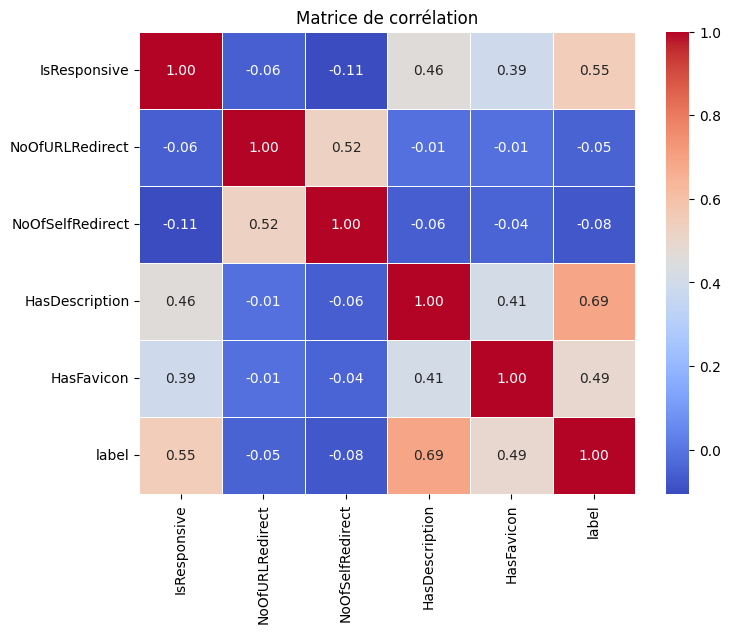

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

**The features "HasFavicon," "HasDescription," and "IsResponsive" are the most correlated with the target variable "label." These columns indicate whether the website includes a favicon, a meta description, and if it is designed to be responsive.**

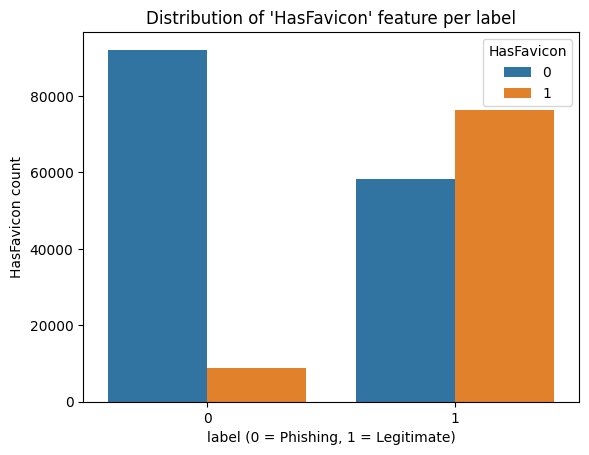

In [ ]:
sns.countplot(x='label', hue='HasFavicon', data=df)
plt.title("Distribution of 'HasFavicon' feature per label")
plt.xlabel("label (0 = Phishing, 1 = Legitimate)")
plt.ylabel("HasFavicon count")
plt.legend(title="HasFavicon", labels=["0", "1"])
plt.show()

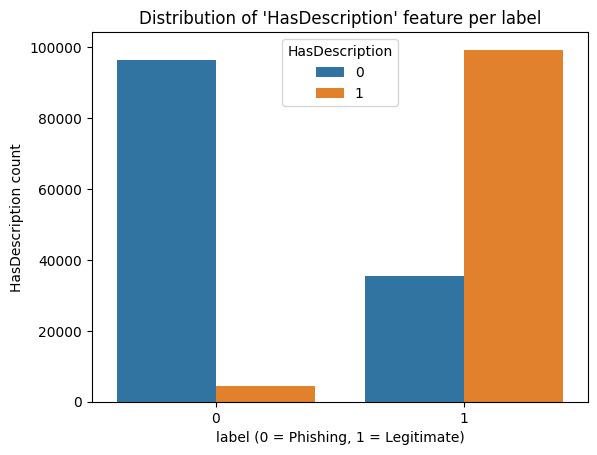

In [ ]:
sns.countplot(x='label', hue='HasDescription', data=df)
plt.title("Distribution of 'HasDescription' feature per label")
plt.xlabel("label (0 = Phishing, 1 = Legitimate)")
plt.ylabel("HasDescription count")
plt.legend(title="HasDescription", labels=["0", "1"])
plt.show()

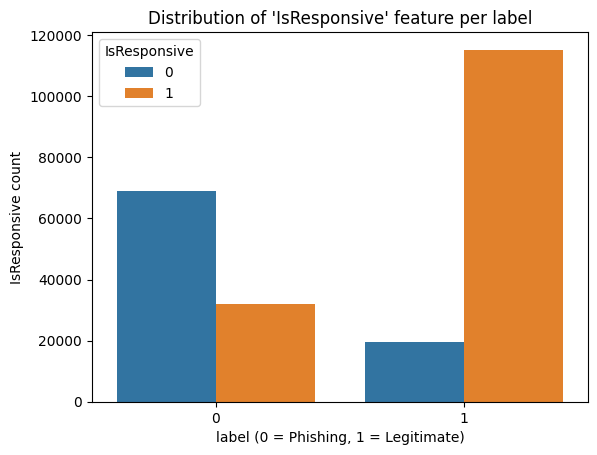

In [ ]:
sns.countplot(x='label', hue='IsResponsive', data=df)
plt.title("Distribution of 'IsResponsive' feature per label")
plt.xlabel("label (0 = Phishing, 1 = Legitimate)")
plt.ylabel("IsResponsive count")
plt.legend(title="IsResponsive", labels=["0", "1"])
plt.show()

**We observe that most websites lacking a favicon or meta description are phishing websites. Additionally, websites that are responsive are more likely to be legitimate.**

#### 5. Interactive Elements

In [ ]:
columns_of_interest = [
    'HasExternalFormSubmit',
    'HasSocialNet',
    'HasSubmitButton',
    'HasHiddenFields',
    'HasPasswordField',
    "label"
]

df_reduced = df[columns_of_interest]
df_reduced.head()

,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,label
0,0,0,1,1,0,1
1,0,1,1,0,0,1
2,0,0,1,1,0,1
3,0,1,1,1,0,1
4,0,1,1,1,0,1


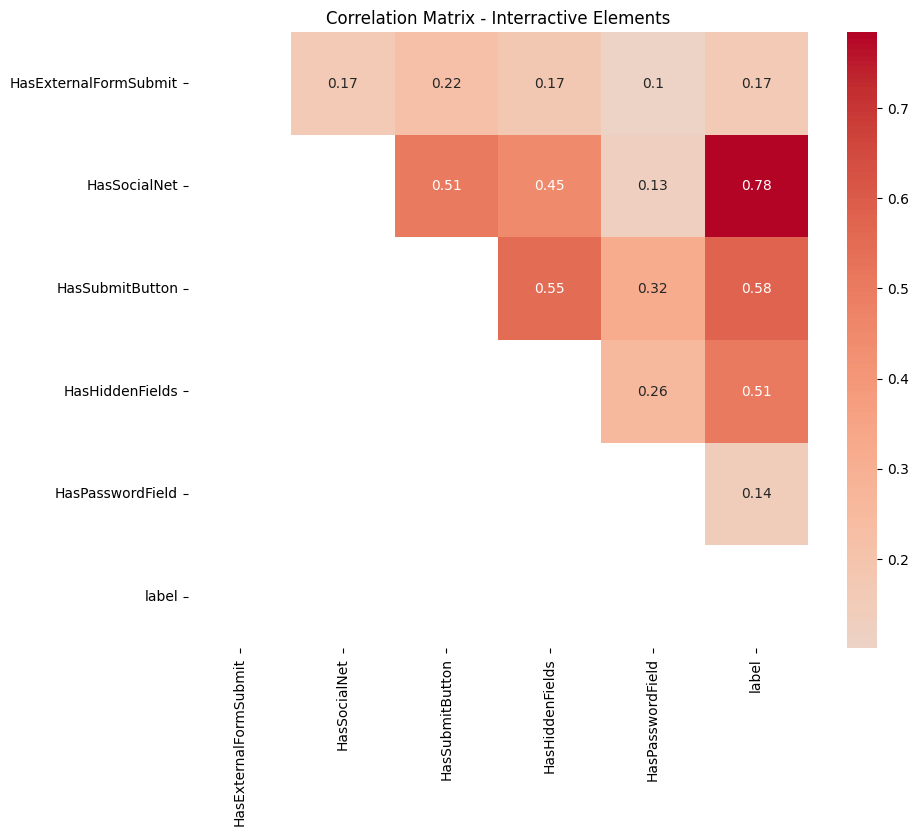

In [ ]:
correlation_matrix = df_reduced.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix - Interractive Elements')
plt.show()

'**HasSocialNet**', which indicates the presence or absence of social network links or icons on the web page, is the most correlated with '**label**'.

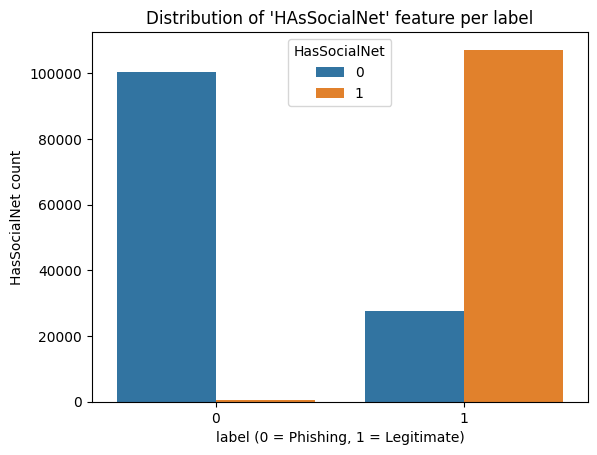

In [ ]:
sns.countplot(x='label', hue='HasSocialNet', data=df)
plt.title("Distribution of 'HAsSocialNet' feature per label")
plt.xlabel("label (0 = Phishing, 1 = Legitimate)")
plt.ylabel("HasSocialNet count")
plt.legend(title="HasSocialNet", labels=["0", "1"])
plt.show()

In [ ]:
df[df['HasSocialNet']==0]['label'].value_counts()[0] / df[df['HasSocialNet']==0]['label'].shape[0] * 100

78.37955953737377

We note that **all sites containing links to social networks are legitimate sites**, and only a small proportion (23.5%) of sites that do not contain links to social networks are phishing sites.

#### 6. Response/Behavior Analysis

In [ ]:
pd.crosstab(df['Bank'], df['label'],normalize='all',margins=True) * 100

label,0,1,All
Bank,,,
0,40.483895,46.807184,87.291079
1,2.326597,10.382324,12.708921
All,42.810492,57.189508,100.000000


In [ ]:
pd.crosstab(df['Pay'], df['label'],normalize='all',margins=True) * 100

label,0,1,All
Pay,,,
0,40.233678,36.065650,76.299328
1,2.576815,21.123858,23.700672
All,42.810492,57.189508,100.000000


In [ ]:
pd.crosstab(df['Crypto'], df['label'],normalize='all',margins=True) * 100

label,0,1,All
Crypto,,,
0,42.551793,55.100829,97.652622
1,0.258699,2.088679,2.347378
All,42.810492,57.189508,100.000000


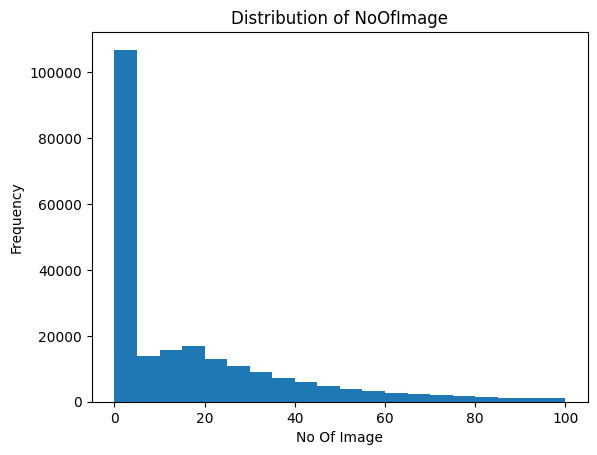

In [ ]:
filtered_data = df[df['NoOfImage'] <= 100]
plt.hist(filtered_data['NoOfImage'],bins=20)
plt.xlabel('No Of Image')
plt.ylabel('Frequency')
plt.title('Distribution of NoOfImage')
plt.show()

In [ ]:
print("Number of values equal to 0: " + str(len(df[df['NoOfImage'] == 0])))
print("Percentage of values equal to 0: " + str(round(100 * len(df[df['NoOfImage'] == 0]) / len(df), 2)) + "%")
print("Number of values greater than 100: " + str(len(df[df['NoOfImage'] > 100])))
print("Percentage of values greater than 100: " + str(round(100 * len(df[df['NoOfImage'] > 100]) / len(df), 2)) + "%")

Number of values equal to 0: 85521
Percentage of values equal to 0: 36.27%
Number of values greater than 100: 10887
Percentage of values greater than 100: 4.62%


In [ ]:
df_filtered = df[(df['NoOfImage'] < 10) & (df['label'] == 0)]
percentage = (len(df_filtered) / len(df[(df['NoOfImage'] < 10)])) * 100
print(f"Percentage of NoOfImage < 10 with label 0: {percentage:.2f}%")

Percentage of NoOfImage < 10 with label 0: 80.86%


In [ ]:
df_filtered = df[(df['NoOfImage'] < 50) & (df['label'] == 0)]
percentage = (len(df_filtered) / len(df[(df['NoOfImage'] < 50)])) * 100
print(f"Percentage of NoOfImage < 50 with label 0: {percentage:.2f}%")

Percentage of NoOfImage < 50 with label 0: 49.47%


We found the same trends with NoOfCSS, NoOfJS, NoOfSelfRef, NoOfEmptyRef, and NoOfExternalRef. The distribution is skewed to the left with some outliers for values above 100. Also, the lower the value, the more likely it is not phishing, which is confirmed by the correlation matrix above.

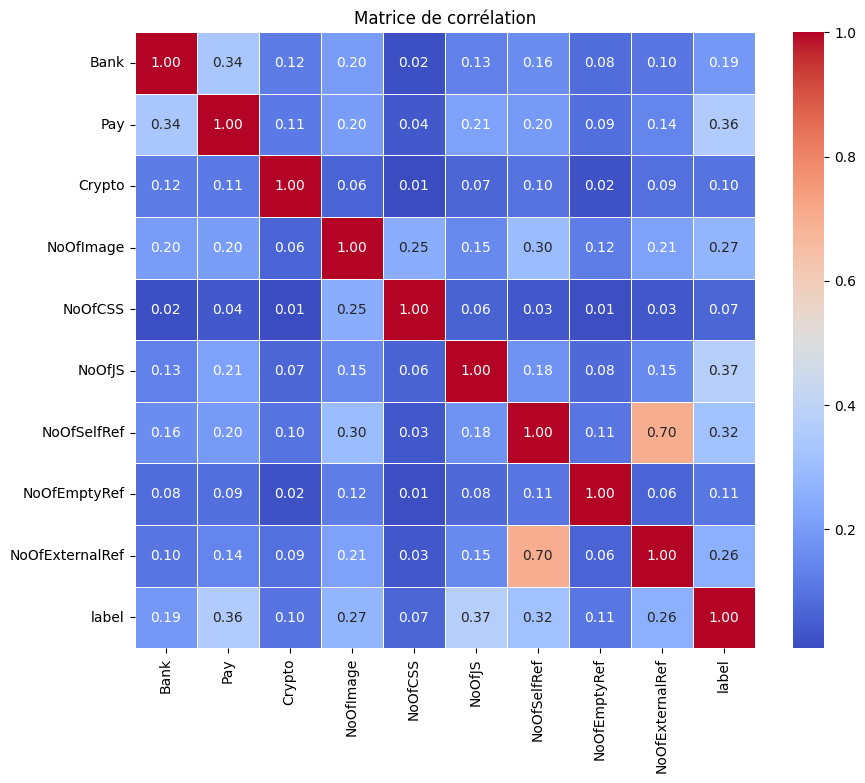

In [ ]:
df2=df[["Bank",
"Pay",
"Crypto",
"NoOfImage",
"NoOfCSS",
"NoOfJS",
"NoOfSelfRef",
"NoOfEmptyRef",
"NoOfExternalRef",
"label"
]]
matrice_corr = df2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

### **Feature engineering**

We considered adding new variables to our dataset to capture patterns that may help distinguish between legitimate and phishing URLs.

*Interactivity Score* : This feature/score indicates the level of user engagement and potential data collection.

In [ ]:
df['InteractivityScore'] = df[['HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField']].sum(axis=1)

*URLComplexityScore* : This score measures the complexity of the URL

In [ ]:
df['URLComplexityScore'] = df[['NoOfSubDomain', 'NoOfObfuscatedChar',   'NoOfOtherSpecialCharsInURL', 'ObfuscationRatio']].sum(axis=1)

*MediaContentScore* : This score evaluates the richness of the website’s media content

In [ ]:
df['MediaContentScore'] = df[['NoOfImage', 'NoOfCSS', 'NoOfJS']].sum(axis=1)

*TrustworthinessScore*: This score signals if the page has sensitive or financial content

In [ ]:
df['TrustworthinessScore'] = df[['Bank', 'Pay', 'Crypto']].sum(axis=1)

*CharacterDiversityIndex* : Characteristic based on the diversity of characters in the URL

In [ ]:
df['CharacterDiversityIndex'] = (df['NoOfLettersInURL'] + df['NoOfDegitsInURL'] + df['NoOfOtherSpecialCharsInURL']) / df['URLLength']

#### **Visualize their correlation with the target variable**

In [ ]:
added_features = [
    'InteractivityScore',
    'URLComplexityScore',
    'MediaContentScore',
    'TrustworthinessScore',
    'CharacterDiversityIndex',
    "label"
]

df_added = df[added_features]
df_added.head()

,InteractivityScore,URLComplexityScore,MediaContentScore,TrustworthinessScore,CharacterDiversityIndex,label
0,2,2.0,82,1,0.612903,1
1,2,3.0,67,0,0.478261,1
2,2,4.0,19,0,0.586207,1
3,3,2.0,45,2,0.538462,1
4,3,2.0,293,2,0.636364,1


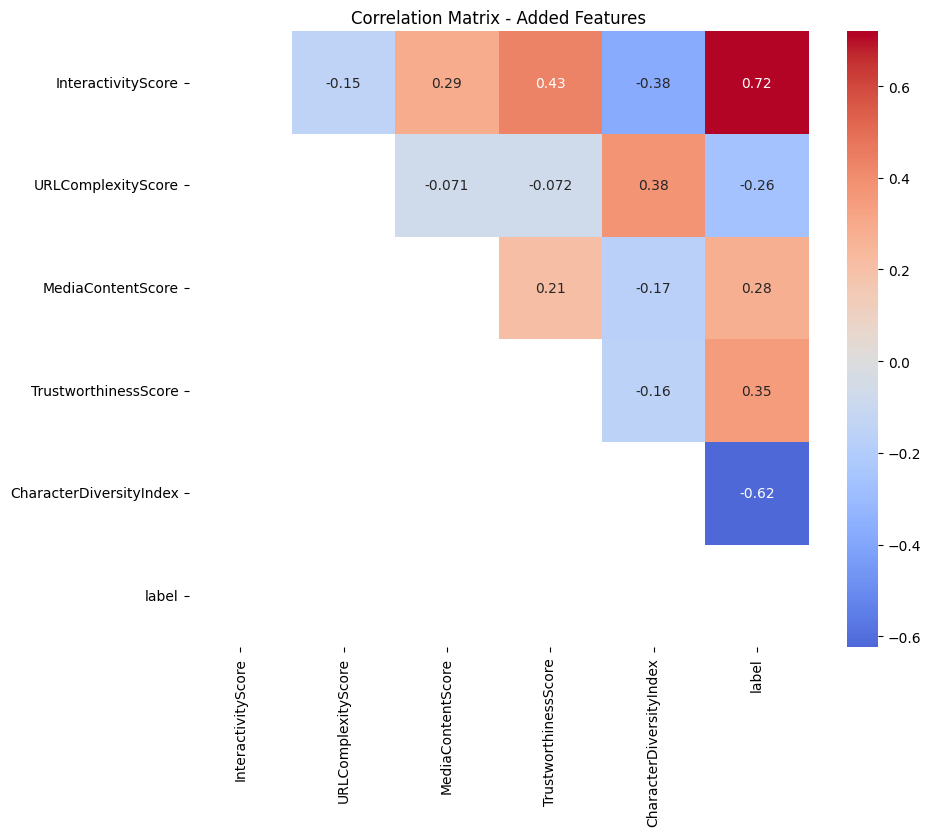

In [ ]:
correlation_matrix = df_added.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix - Added Features')
plt.show()

The correlation matrix shows that the new features effectively differentiate between phishing and legitimate sites. High InteractivityScore and TrustworthinessScore correlate with legitimate sites, while URLComplexityScore and CharacterDiversityIndex correlate with phishing one.

### **Data preprocessing**

In [ ]:
columns_to_remove = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title', 'label','NoOfQMarkInURL','NoOfAmpersandInURL']
X = df.drop(columns=columns_to_remove)
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### **Benchmark of classification techniques and construction of a prediction model**

#### Models training and evaluation function

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    model_accuracy = accuracy_score(y_val, y_val_pred)
    model_f1_score = f1_score(y_val, y_val_pred)
    print(f"Validation Accuracy for {model.__class__.__name__}: {model_accuracy}")
    print(f"Validation F1-Score for {model.__class__.__name__}: {model_f1_score}")
    return model_accuracy,model_f1_score


#### Hyperparameters tuning function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.model_selection import GridSearchCV

def perform_grid_search_and_evaluation(model, param_grid, X_train, X_val, y_train, y_val, X_test, y_test):
    f1_scorer = make_scorer(f1_score, average='weighted', zero_division=1)

    # Combine train and validation sets
    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)

    # Grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                               scoring={'f1_weighted': f1_scorer}, refit='f1_weighted',
                               return_train_score=True, n_jobs=-1)
    grid_search.fit(X_combined, y_combined)

    # Extracting results
    results = grid_search.cv_results_
    best_model = grid_search.best_estimator_

    # Generate heatmap only if there are two parameters in the grid
    param_keys = list(param_grid.keys())
    if len(param_keys) >= 2:
        param1, param2 = param_keys[0], param_keys[1]
        scores = results['mean_test_f1_weighted']

        param1_values = param_grid[param1]
        param2_values = param_grid[param2]

        # If the number of combinations doesn't match, print the shape of scores
        if len(scores) != len(param1_values) * len(param2_values):
            print(f"Shape mismatch: {len(scores)} != {len(param1_values) * len(param2_values)}")

        # Reshape the F1 matrix
        f1_matrix = np.array(scores).reshape(len(param1_values), len(param2_values))

        # Create a new figure for each heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(f1_matrix, xticklabels=param2_values, yticklabels=param1_values,
                    cmap='viridis', annot=True, fmt='.5f')
        plt.xlabel(param2)
        plt.ylabel(param1)
        plt.title('F1 Score Heatmap')
        plt.show()

    # Evaluate on the test set
    y_test_pred = best_model.predict(X_test)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=1)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=1)

    print("Best Model:", best_model)
    print("Best Parameters:", grid_search.best_params_)
    print(f"Test Recall: {test_recall}")
    print(f"Test F1 Score: {test_f1}")

    return grid_search.best_params_, test_recall, test_f1


### **Models**

##### **Decision Tree**

In [ ]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_accuracy,tree_f1_score = train_and_evaluate(tree_model, X_train, y_train, X_val, y_val)

Validation Accuracy for DecisionTreeClassifier: 0.9992366088468553
Validation F1-Score for DecisionTreeClassifier: 0.9993336294980009


##### **Random Forest Model**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_accuracy,rf_f1_score = train_and_evaluate(rf_model, X_train, y_train, X_val, y_val)

Validation Accuracy for RandomForestClassifier: 0.9998303575215234
Validation F1-Score for RandomForestClassifier: 0.9998519505514842


##### **Logistic Regression**


In [ ]:
model_reg = LogisticRegression(max_iter=1000)
reg_accuracy,reg_f1_score = train_and_evaluate(model_reg, X_train, y_train, X_val, y_val)

Validation Accuracy for LogisticRegression: 0.9996607150430468
Validation F1-Score for LogisticRegression: 0.9997038791827065


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### **MLP**

In [ ]:
model_MLP = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_MLP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


def train_and_evaluate_MLP(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Prédictions
    y_val_pred_probs = model.predict(X_val)
    y_val_pred = (y_val_pred_probs > 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    return accuracy, f1


mlp_accuracy, mlp_f1_score = train_and_evaluate_MLP(model_MLP, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
print(mlp_accuracy)
print(mlp_f1_score)

0.9971584884855168
0.9975237461655024


##### **XGBoost**

In [ ]:
xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="logloss")
xgb_accuracy,xgb_f1_score = train_and_evaluate(xgb_model, X_train, y_train, X_val, y_val)

Validation Accuracy for XGBClassifier: 0.9998727681411426
Validation F1-Score for XGBClassifier: 0.9998889670232058


##### **Linear SVM**

In [ ]:
svm_model = LinearSVC(C=1.0, random_state=42)
svm_accuracy, svm_f1_score = train_and_evaluate(svm_model, X_train, y_train, X_val, y_val)

Validation Accuracy for LinearSVC: 0.9954620637007506
Validation F1-Score for LinearSVC: 0.9960321874884117


### **Hyperparameter tunning**

##### **Decision Tree**

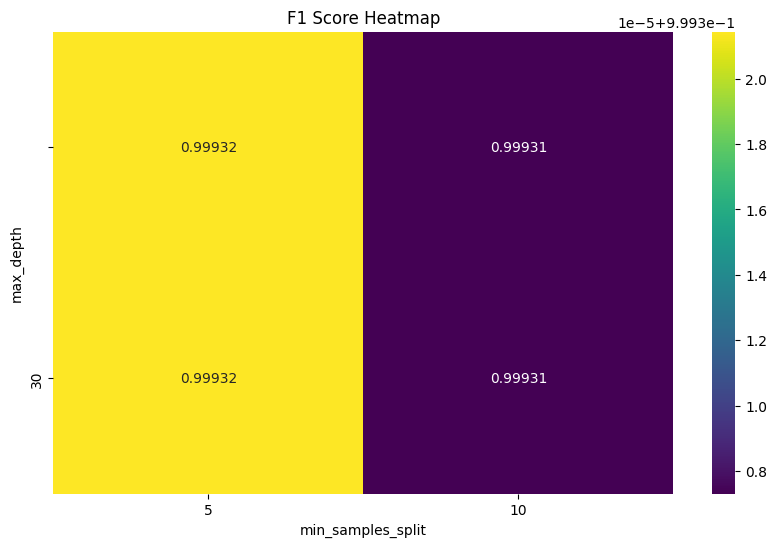

Best Model: DecisionTreeClassifier(min_samples_split=5, random_state=42)
Best Parameters: {'max_depth': None, 'min_samples_split': 5}
Test Recall: 0.9991094147582698
Test F1 Score: 0.9991094204444099


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
param_grid = {
    'max_depth': [None, 30],
    'min_samples_split': [5, 10]
}

best_parameters_dt, recall_score_dt , F1_score_dt = perform_grid_search_and_evaluation(tree_model, param_grid, X_train, X_val, y_train, y_val, X_test, y_test)

##### **Random Forest**

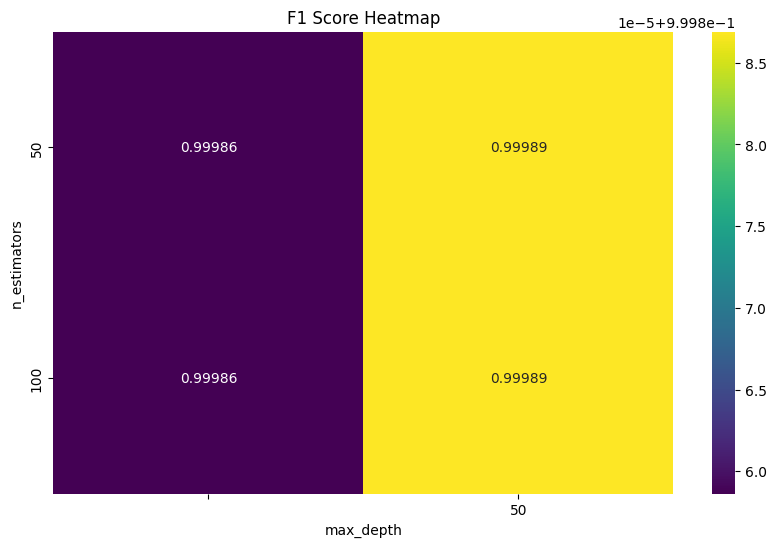

Best Model: RandomForestClassifier(random_state=42)
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Test Recall: 0.9998727735368956
Test F1 Score: 0.9998727759723474


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 50],
}

rf_model = RandomForestClassifier(random_state=42)
best_parameters_rf, recall_score_rf, F1_score_rf = perform_grid_search_and_evaluation(rf_model, param_grid, X_train, X_val, y_train, y_val, X_test, y_test)

##### **XGBoost**

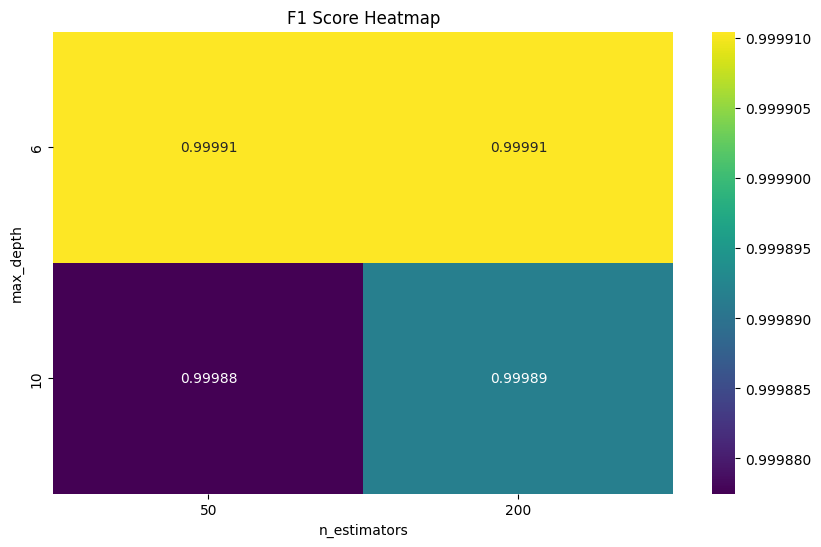

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best Parameters: {'max_depth': 6, 'n_estimators': 200}
Test Recall: 0.9999151823579304
Test F1 Score: 0.999915183440679


In [ ]:
import xgboost as xgb
param_grid = {
    "max_depth": [6, 10],
    "n_estimators": [50, 200],
}

xgb_model = xgb.XGBClassifier()
best_parameters_Xgb, recall_score_Xgb, F1_score_Xgb = perform_grid_search_and_evaluation(xgb_model, param_grid, X_train, X_val, y_train, y_val, X_test, y_test)

##### **Linear SVM**

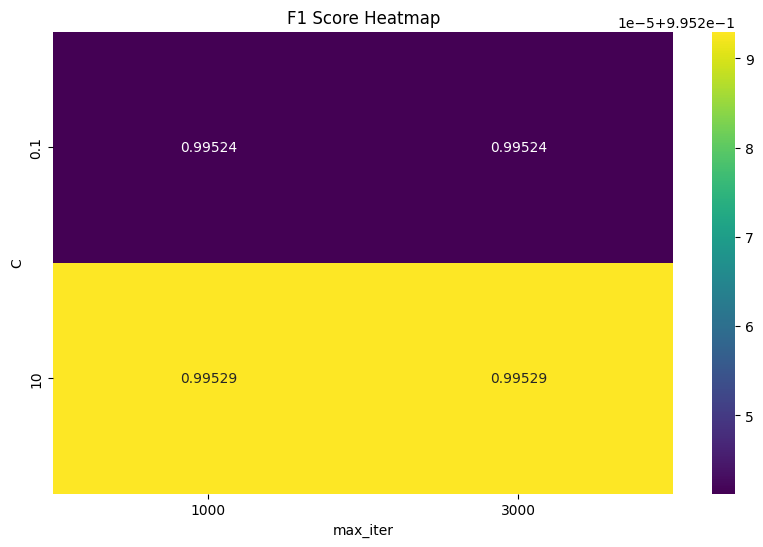

Best Model: LinearSVC(C=10, random_state=42)
Best Parameters: {'C': 10, 'max_iter': 1000}
Test Recall: 0.9952926208651399
Test F1 Score: 0.995293662053004


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


In [ ]:
param_grid_svm = {
    'C': [0.1, 10],
    'max_iter': [1000, 3000]
}

svm_model = LinearSVC(random_state=42)
best_parameters_svm, recall_score_svm, F1_score_svm = perform_grid_search_and_evaluation(
    svm_model, param_grid_svm, X_train, X_val, y_train, y_val, X_test, y_test
)

#### **Best hyperparamters for our models**

In [ ]:
tree_model = DecisionTreeClassifier(**best_parameters_dt, random_state=42)


In [ ]:
rf_model = RandomForestClassifier(**best_parameters_rf, random_state=42)

In [ ]:
xgb_model = XGBClassifier(**best_parameters_Xgb, objective="binary:logistic", eval_metric="logloss")

In [ ]:
svm_model = LinearSVC(**best_parameters_svm, random_state=42)

### Models Comparaison

<ipython-input-76-03f0bc79cceb>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, ax=ax, palette="viridis")
<ipython-input-76-03f0bc79cceb>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, ax=ax, palette="viridis")
<ipython-input-76-03f0bc79cceb>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, ax=ax, palette="viridis")
<ipython-input-76-03f0bc79cceb>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v

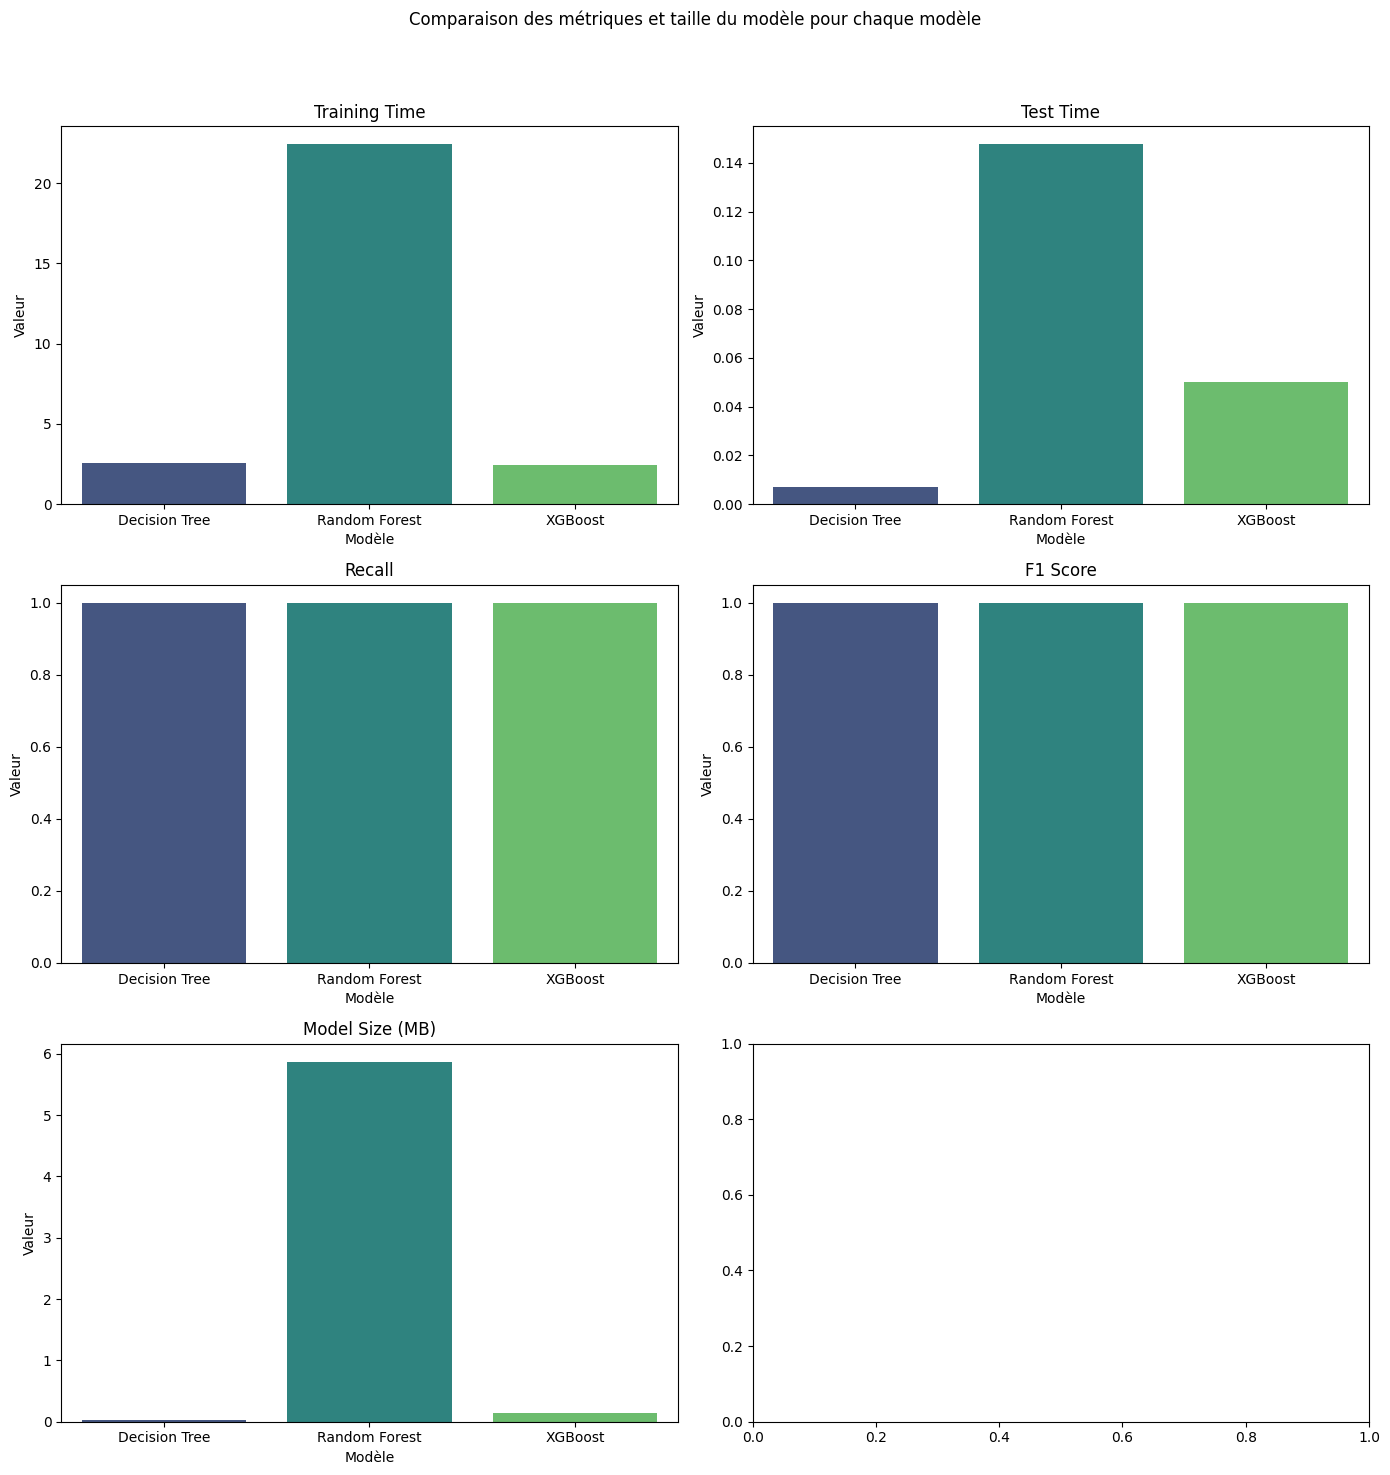

In [ ]:
import os
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, f1_score
import pandas as pd
import numpy as np

# Dictionnaire des modèles à évaluer
models = {
    "Decision Tree": tree_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

# Dictionnaires pour stocker les métriques pour chaque modèle
training_times = {}
test_times = {}
recalls = {}
f1_scores = {}
model_sizes = {}

# Fonction d'évaluation des temps, des scores, et de la taille du modèle
def evaluate_metrics_and_size(model, model_name, X_train, y_train, X_test, y_test):
    import time
    # Mesure du temps d'entraînement
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train

    # Mesure du temps de prédiction
    start_test = time.time()
    y_pred = model.predict(X_test)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcul des scores
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Sauvegarde et mesure de la taille du modèle en Mo
    model_filename = f"{model_name}_model.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)  # Taille en Mo

    return training_time, test_time, recall, f1, model_size

# Boucle pour évaluer chaque modèle
for model_name, model in models.items():
    train_time, test_time, recall, f1, size = evaluate_metrics_and_size(model, model_name, X_train, y_train, X_test, y_test)
    training_times[model_name] = train_time
    test_times[model_name] = test_time
    recalls[model_name] = recall
    f1_scores[model_name] = f1
    model_sizes[model_name] = size

# Création d'un DataFrame pour faciliter le traçage
data = {
    "Model": list(models.keys()),
    "Training Time": list(training_times.values()),
    "Test Time": list(test_times.values()),
    "Recall": list(recalls.values()),
    "F1 Score": list(f1_scores.values()),
    "Model Size (MB)": list(model_sizes.values())
}
df = pd.DataFrame(data)

# Liste des métriques pour générer un subplot pour chacune
metrics = ["Training Time", "Test Time", "Recall", "F1 Score", "Model Size (MB)"]

# Création des subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 15))  # 3x2 pour inclure toutes les métriques
fig.suptitle("Comparaison des métriques et taille du modèle pour chaque modèle")

# Associer chaque subplot à une métrique
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]  # Positionnement dans la grille 3x2
    sns.barplot(x="Model", y=metric, data=df, ax=ax, palette="viridis")
    ax.set_title(f"{metric}")
    ax.set_xlabel("Modèle")
    ax.set_ylabel("Valeur")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustement pour le titre global
plt.show()

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    model_f1_score = f1_score(y_val, y_val_pred)
    print(f"Validation F1-Score for {model.__class__.__name__}: {model_f1_score}")
    return model_f1_score

def select_best_features(X, y, num_features):
    correlations = X.apply(lambda col: col.corr(y))
    correlations_abs = correlations.abs()
    best_features_indices = correlations_abs.nlargest(num_features).index
    X_selected = X[best_features_indices]
    return X_selected, best_features_indices

def plot_f1_vs_features(X, y, X_val, y_val, tree_model, rf_model, xgb_model):
    f1_tree = []
    f1_rf = []
    f1_xgb = []
    num_features_list = []

    num_features = X.shape[1]
    while num_features > 6:
        X_selected, selected_indices = select_best_features(X, y, num_features)
        X_val_selected = X_val[selected_indices]
        f1_tree.append(train_and_evaluate(tree_model, X_selected, y, X_val_selected, y_val))
        f1_rf.append(train_and_evaluate(rf_model, X_selected, y, X_val_selected, y_val))
        f1_xgb.append(train_and_evaluate(xgb_model, X_selected, y, X_val_selected, y_val))
        num_features_list.append(num_features)
        num_features -= 5

    for num_features in range(6, 0, -1):
        X_selected, selected_indices = select_best_features(X, y, num_features)
        X_val_selected = X_val[selected_indices]
        f1_tree.append(train_and_evaluate(tree_model, X_selected, y, X_val_selected, y_val))
        f1_rf.append(train_and_evaluate(rf_model, X_selected, y, X_val_selected, y_val))
        f1_xgb.append(train_and_evaluate(xgb_model, X_selected, y, X_val_selected, y_val))
        num_features_list.append(num_features)

    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, f1_tree, label="Decision Tree", marker='o')
    plt.plot(num_features_list, f1_rf, label="Random Forest", marker='o')
    plt.plot(num_features_list, f1_xgb, label="XGBoost", marker='o')

    plt.title("F1-Score vs Number of Features")
    plt.xlabel("Number of Features")
    plt.ylabel("F1-Score")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
tree_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, objective="binary:logistic", eval_metric="logloss")

In [ ]:
plot_f1_vs_features(X_train, y_train, X_val, y_val, tree_model, rf_model, xgb_model)

### **Consideration of additional features**

##### **Sensitivity of previously removed features and new features**

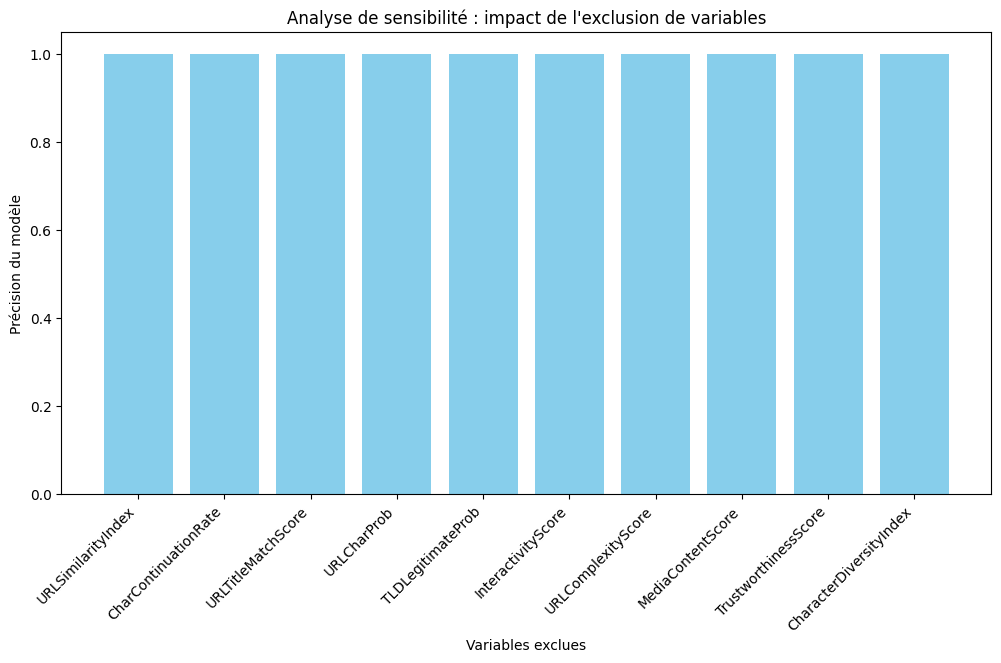

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def sensitive_analysis(df,model):
    columns_to_remove = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title','NoOfQMarkInURL','NoOfAmpersandInURL']
    df.drop(columns=columns_to_remove,inplace=True)
    variables_a_tester = [
        'URLSimilarityIndex', 'CharContinuationRate', 'URLTitleMatchScore',
        'URLCharProb', 'TLDLegitimateProb',
        'InteractivityScore', 'URLComplexityScore', 'MediaContentScore',
        'TrustworthinessScore', 'CharacterDiversityIndex'
    ]

    accuracies = []
    for variable_a_supprimer in variables_a_tester:
        X = df.drop(columns=[variable_a_supprimer, 'label'])
        y = df['label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    plt.figure(figsize=(12, 6))
    plt.bar(variables_a_tester, accuracies, color='skyblue')
    plt.xlabel("Variables exclues")
    plt.ylabel("Précision du modèle")
    plt.title("Analyse de sensibilité : impact de l'exclusion de variables")
    plt.xticks(rotation=45, ha="right")
    plt.show()

sensitive_analysis(df,xgb_model)

### Competition phase

### Preparing train and test set

In [ ]:
def preparing_data(path):
    df = pd.read_csv(path,delimiter=",")
    df.drop('Unnamed: 0', axis=1, inplace=True)
    columns_to_remove = [
    'URLSimilarityIndex',
    'CharContinuationRate',
    'URLTitleMatchScore',
    'URLCharProb',
    'TLDLegitimateProb'
    ]
    df.drop(columns_to_remove, axis=1, inplace=True)
    df['InteractivityScore'] = df[['HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField']].sum(axis=1)
    df['URLComplexityScore'] = df[['NoOfSubDomain', 'NoOfObfuscatedChar',   'NoOfOtherSpecialCharsInURL', 'ObfuscationRatio']].sum(axis=1)
    df['MediaContentScore'] = df[['NoOfImage', 'NoOfCSS', 'NoOfJS']].sum(axis=1)
    df['TrustworthinessScore'] = df[['Bank', 'Pay', 'Crypto']].sum(axis=1)
    df['CharacterDiversityIndex'] = (df['NoOfLettersInURL'] + df['NoOfDegitsInURL'] + df['NoOfOtherSpecialCharsInURL']) / df['URLLength']
    columns_to_remove = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title','NoOfQMarkInURL','NoOfAmpersandInURL']
    df.drop(columns=columns_to_remove,inplace=True)
    X=df.drop('label',axis=1)
    y=df['label']
    return X,y

In [ ]:
X_train, y_train=preparing_data('/content/Testing_for_evaluation')
X_test,y_test=preparing_data('/content/Testing_for_evaluation')

### Training and testing our best model

In [ ]:
model = xgb_model

In [ ]:
import time

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):

  start_train = time.time()
  model.fit(X_train, y_train)
  end_train = time.time()
  train_time = end_train - start_train

  start_test = time.time()
  y_pred = model.predict(X_test)
  end_test = time.time()
  test_time = end_test - start_test

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')

  model_filename = "temp_model.pkl"
  with open(model_filename, 'wb') as f:
    pickle.dump(model, f)
  model_size = os.path.getsize(model_filename) / (1024 * 1024)
  os.remove(model_filename)

  return model_size, train_time, test_time, f1, accuracy

In [ ]:
model_size, train_time, test_time, f1, accuracy = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

# **Our best model results**

In [ ]:
GREEN_BOLD = '\033[1;32m'
RESET = '\033[0m'

print(f"{GREEN_BOLD}Model Size (MB): {model_size}{RESET}")
print(f"{GREEN_BOLD}Training Time (s): {train_time}{RESET}")
print(f"{GREEN_BOLD}Test Time (s): {test_time}{RESET}")
print(f"{GREEN_BOLD}F1 Score: {f1}{RESET}")
print(f"{GREEN_BOLD}Accuracy: {accuracy}{RESET}")




Model Size (MB): 0.12054729461669922
Training Time (s): 0.9350192546844482
Test Time (s): 0.1124107837677002
F1 Score: 1.0
Accuracy: 1.0
